In [1]:
from datetime import datetime
import os
import tempfile
from glob import glob

import torch
from torch.utils.data import random_split, DataLoader
import monai
import pandas as pd
import torchio as tio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns

monai.config.print_config()

C:\Users\LESC\Desktop\UNet-SegRD\lesc-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.2.dev2312
Numpy version: 1.24.2
Pytorch version: 1.10.2+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 400a6a052f1b2925db6f1323a67a7cf4546403eb
MONAI __file__: C:\Users\LESC\Desktop\UNet-SegRD\lesc-env\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.0.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: 2.12.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.3+cpu
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional

In [2]:
sns.set()
plt.rcParams["figure.figsize"] = 12, 8
monai.utils.set_determinism()

%load_ext tensorboard

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\LESC\AppData\Local\Temp\tmpufciwlvz


# Data

In [4]:
class MedicalDecathlonDataModule(pl.LightningDataModule):
    def __init__(self, task, batch_size, train_val_ratio):
        super().__init__()
        self.task = task
        self.batch_size = batch_size
        self.base_dir = root_dir
        self.dataset_dir = os.path.join(root_dir, task)
        self.train_val_ratio = train_val_ratio
        self.subjects = None
        self.test_subjects = None
        self.preprocess = None
        self.transform = None
        self.train_set = None
        self.val_set = None
        self.test_set = None

    def get_max_shape(self, subjects):
        import numpy as np

        dataset = tio.SubjectsDataset(subjects)
        shapes = np.array([s.spatial_shape for s in dataset])
        return shapes.max(axis=0)

    def download_data(self):
        if not os.path.isdir(self.dataset_dir):
            url = f"https://msd-for-monai.s3-us-west-2.amazonaws.com/{self.task}.tar"
            monai.apps.download_and_extract(url=url, output_dir=self.base_dir)

        image_training_paths = sorted(glob(os.path.join(self.dataset_dir, "imagesTr", "*.nii*")))
        label_training_paths = sorted(glob(os.path.join(self.dataset_dir, "labelsTr", "*.nii*")))
        image_test_paths = sorted(glob(os.path.join(self.dataset_dir, "imagesTs", "*.nii*")))
        return image_training_paths, label_training_paths, image_test_paths

    def prepare_data(self):
        image_training_paths, label_training_paths, image_test_paths = self.download_data()

        self.subjects = []
        for image_path, label_path in zip(image_training_paths, label_training_paths):
            # 'image' and 'label' are arbitrary names for the images
            subject = tio.Subject(image=tio.ScalarImage(image_path), label=tio.LabelMap(label_path))
            self.subjects.append(subject)

        self.test_subjects = []
        for image_path in image_test_paths:
            subject = tio.Subject(image=tio.ScalarImage(image_path))
            self.test_subjects.append(subject)

    def get_preprocessing_transform(self):
        preprocess = tio.Compose(
            [
                tio.RescaleIntensity((-1, 1)),
                tio.CropOrPad(self.get_max_shape(self.subjects + self.test_subjects)),
                tio.EnsureShapeMultiple(8),  # for the U-Net
                tio.OneHot(),
            ]
        )
        return preprocess

    def get_augmentation_transform(self):
        augment = tio.Compose(
            [
                tio.RandomAffine(),
                tio.RandomGamma(p=0.5),
                tio.RandomNoise(p=0.5),
                tio.RandomMotion(p=0.1),
                tio.RandomBiasField(p=0.25),
            ]
        )
        return augment

    def setup(self, stage=None):
        num_subjects = len(self.subjects)
        num_train_subjects = int(round(num_subjects * self.train_val_ratio))
        num_val_subjects = num_subjects - num_train_subjects
        splits = num_train_subjects, num_val_subjects
        train_subjects, val_subjects = random_split(self.subjects, splits)

        self.preprocess = self.get_preprocessing_transform()
        augment = self.get_augmentation_transform()
        self.transform = tio.Compose([self.preprocess, augment])

        self.train_set = tio.SubjectsDataset(train_subjects, transform=self.transform)
        self.val_set = tio.SubjectsDataset(val_subjects, transform=self.preprocess)
        self.test_set = tio.SubjectsDataset(self.test_subjects, transform=self.preprocess)

    def train_dataloader(self):
        return DataLoader(self.train_set, self.batch_size, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_set, self.batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_set, self.batch_size, num_workers=2)

In [5]:
data = MedicalDecathlonDataModule(
    task="Task04_Hippocampus",
    batch_size=16,
    train_val_ratio=0.8,
)

data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

Task04_Hippocampus.tar: 27.1MB [00:15, 1.88MB/s]                                                                                                                                       

2023-03-23 14:09:32,273 - INFO - Downloaded: C:\Users\LESC\AppData\Local\Temp\tmpp7lydt4n\Task04_Hippocampus.tar


2023-03-23 14:09:32,274 - INFO - Expected md5 is None, skip md5 check for file C:\Users\LESC\AppData\Local\Temp\tmpp7lydt4n\Task04_Hippocampus.tar.
2023-03-23 14:09:32,275 - INFO - Writing into directory: C:\Users\LESC\AppData\Local\Temp\tmpufciwlvz.
Training:   208
Validation:  52
Test:       130


In [6]:
class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        return optimizer

    def prepare_batch(self, batch):
        return batch["image"][tio.DATA], batch["label"][tio.DATA]

    def infer_batch(self, batch):
        x, y = self.prepare_batch(batch)
        y_hat = self.net(x)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        return loss

In [7]:
unet = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(8, 16, 32, 64),
    strides=(2, 2, 2),
)

model = Model(
    net=unet,
    criterion=monai.losses.DiceCELoss(softmax=True),
    learning_rate=1e-2,
    optimizer_class=torch.optim.AdamW,
)
early_stopping = pl.callbacks.early_stopping.EarlyStopping(
    monitor="val_loss",
)
trainer = pl.Trainer(
    gpus=0,
    precision='bf16',
    callbacks=[early_stopping],
)
trainer.logger._default_hp_metric = False

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [8]:
start = datetime.now()
print("Training started at", start)
trainer.fit(model=model, datamodule=data)
print("Training duration:", datetime.now() - start)

C:\Users\LESC\Desktop\UNet-SegRD\lesc-env\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name      | Type       | Params
-----------------------------------------
0 | net       | UNet       | 122 K 
1 | criterion | DiceCELoss | 0     
-----------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.490     Total estimated model params size (MB)


Training started at 2023-03-23 14:09:43.850049
Validation sanity check:   0%|                                                                                                                                   | 0/2 [00:00<?, ?it/s]

C:\Users\LESC\Desktop\UNet-SegRD\lesc-env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████████████████████████████████████████████████████████████▌                                                             | 1/2 [00:10<00:10, 10.30s/it]

C:\Users\LESC\Desktop\UNet-SegRD\lesc-env\lib\site-packages\pytorch_lightning\utilities\data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


C:\Users\LESC\Desktop\UNet-SegRD\lesc-env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\LESC\Desktop\UNet-SegRD\lesc-env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  76%|███████████████████████████████████████████████████████████████████████████▋                       | 13/17 [02:37<00:48, 12.10s/it, loss=1.13, v_num=2, train_loss=0.775]
Validating: 0it [00:00, ?it/s]
Epoch 1:   0%|                                                                                                            | 0/17 [00:00<?, ?it/s, loss=1.13, v_num=2, train_loss=0.775]

C:\Users\LESC\Desktop\UNet-SegRD\lesc-env\lib\site-packages\pytorch_lightning\utilities\data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 1:  76%|██████████████████████████████████████████████████████████████████████████▉                       | 13/17 [02:33<00:47, 11.78s/it, loss=0.748, v_num=2, train_loss=0.610]
Validating: 0it [00:00, ?it/s]
Epoch 2:  76%|██████████████████████████████████████████████████████████████████████████▉                       | 13/17 [02:34<00:47, 11.91s/it, loss=0.583, v_num=2, train_loss=0.519]
Validating: 0it [00:00, ?it/s]
Epoch 3:  76%|██████████████████████████████████████████████████████████████████████████▉                       | 13/17 [02:34<00:47, 11.88s/it, loss=0.512, v_num=2, train_loss=0.483]
Validating: 0it [00:00, ?it/s]
Epoch 4:  76%|███████████████████████████████████████████████████████████████████████████▋                       | 13/17 [02:33<00:47, 11.80s/it, loss=0.47, v_num=2, train_loss=0.442]
Validating: 0it [00:00, ?it/s]
Epoch 5:  76%|██████████████████████████████████████████████████████████████████████████▉                       | 13/17 [02:27<00:45, 11.31s

In [11]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 2476), started 0:59:58 ago. (Use '!kill 2476' to kill it.)

In [13]:
model.to("cpu")
all_dices = []
get_dice = monai.metrics.DiceMetric(include_background=False, reduction="none")
with torch.no_grad():
    for batch in data.val_dataloader():
        inputs, targets = model.prepare_batch(batch)
        logits = model.net(inputs.to(model.device))
        labels = logits.argmax(dim=1)
        labels_one_hot = torch.nn.functional.one_hot(labels).permute(0, 4, 1, 2, 3)
        get_dice(labels_one_hot.to(model.device), targets.to(model.device))
    metric = get_dice.aggregate()
    get_dice.reset()
    all_dices.append(metric)
all_dices = torch.cat(all_dices)

C:\Users\LESC\Desktop\UNet-SegRD\lesc-env\lib\site-packages\numpy\lib\arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)


Text(0.5, 1.0, 'Dice scores')

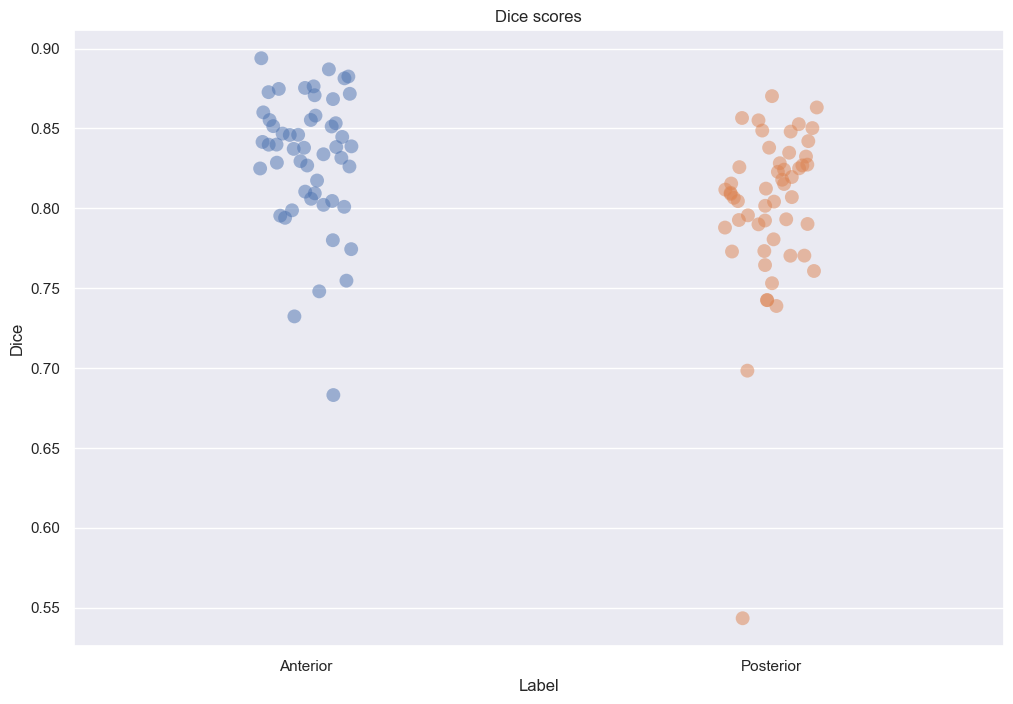

In [14]:
records = []
for ant, post in all_dices:
    records.append({"Dice": ant, "Label": "Anterior"})
    records.append({"Dice": post, "Label": "Posterior"})
df = pd.DataFrame.from_records(records)
ax = sns.stripplot(x="Label", y="Dice", data=df, size=10, alpha=0.5)
ax.set_title("Dice scores")

In [15]:
with torch.no_grad():
    for batch in data.test_dataloader():
        inputs = batch["image"][tio.DATA].to(model.device)
        labels = model.net(inputs).argmax(dim=1, keepdim=True).cpu()
        break
batch_subjects = tio.utils.get_subjects_from_batch(batch)
tio.utils.add_images_from_batch(batch_subjects, labels, tio.LabelMap)

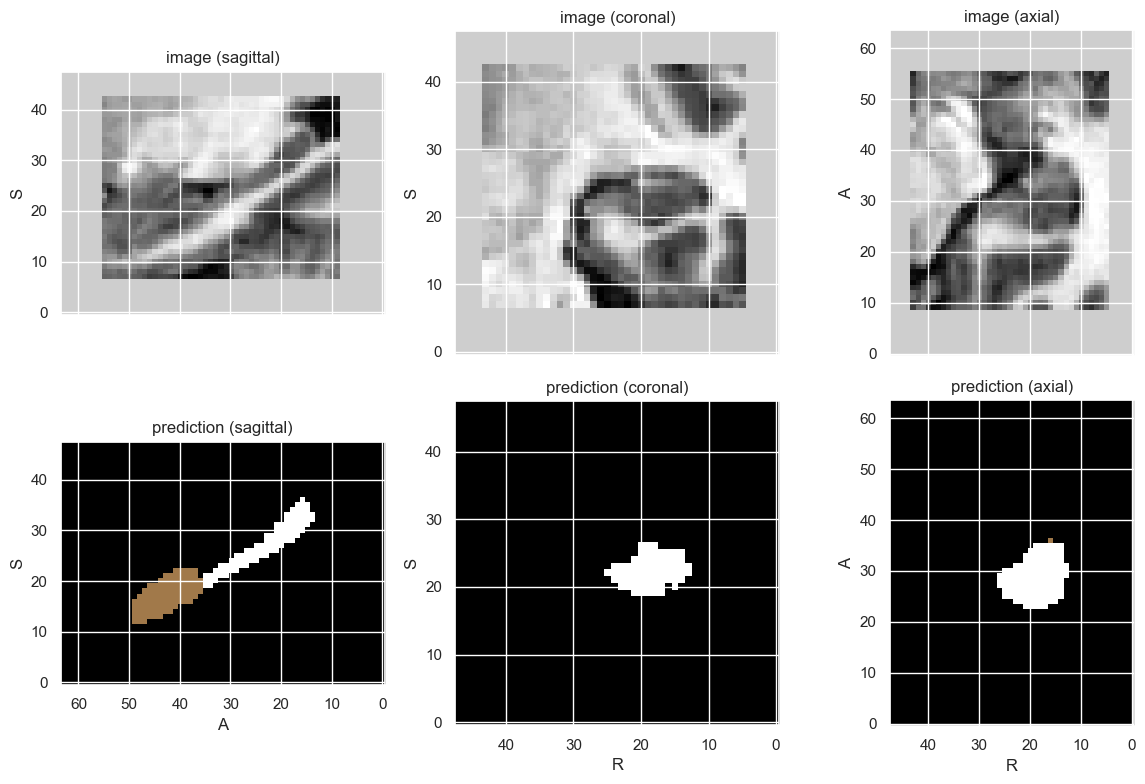

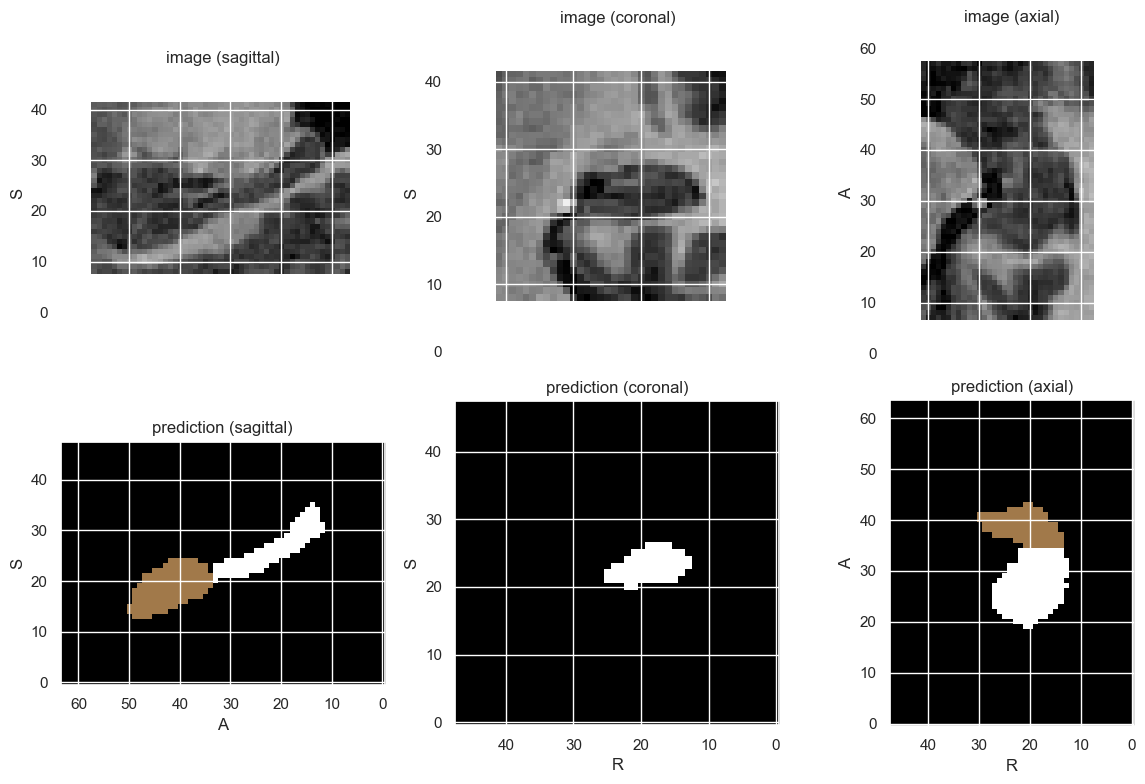

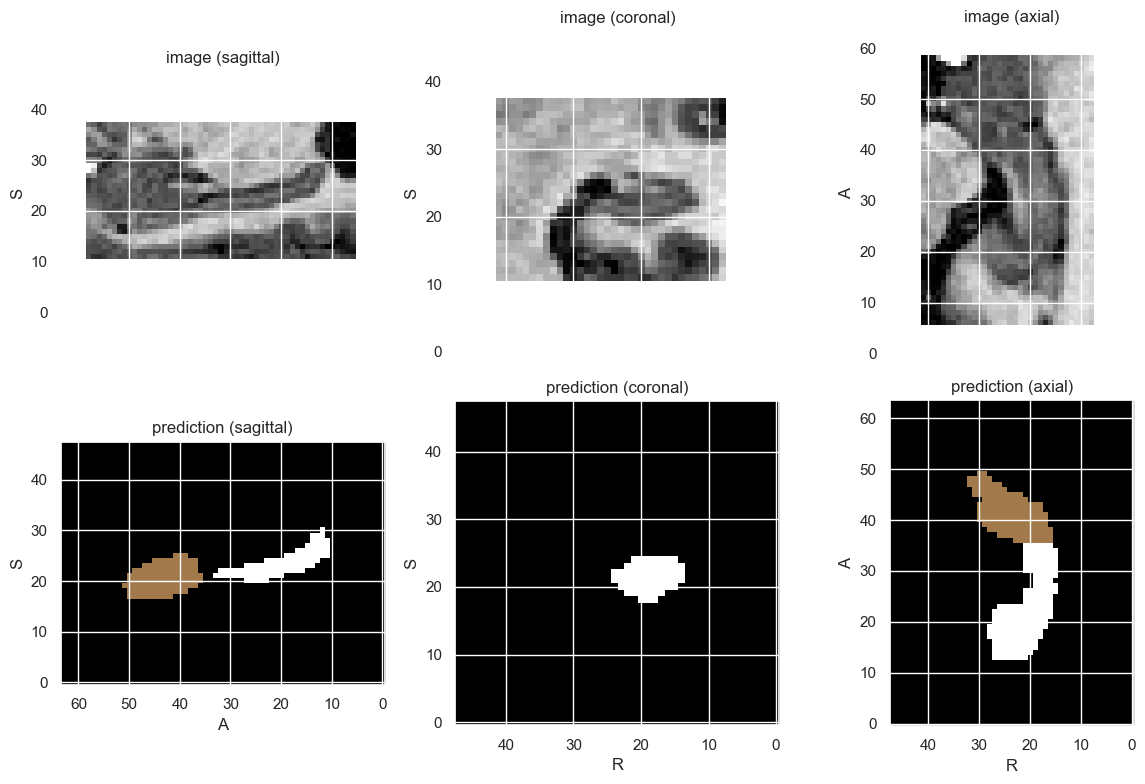

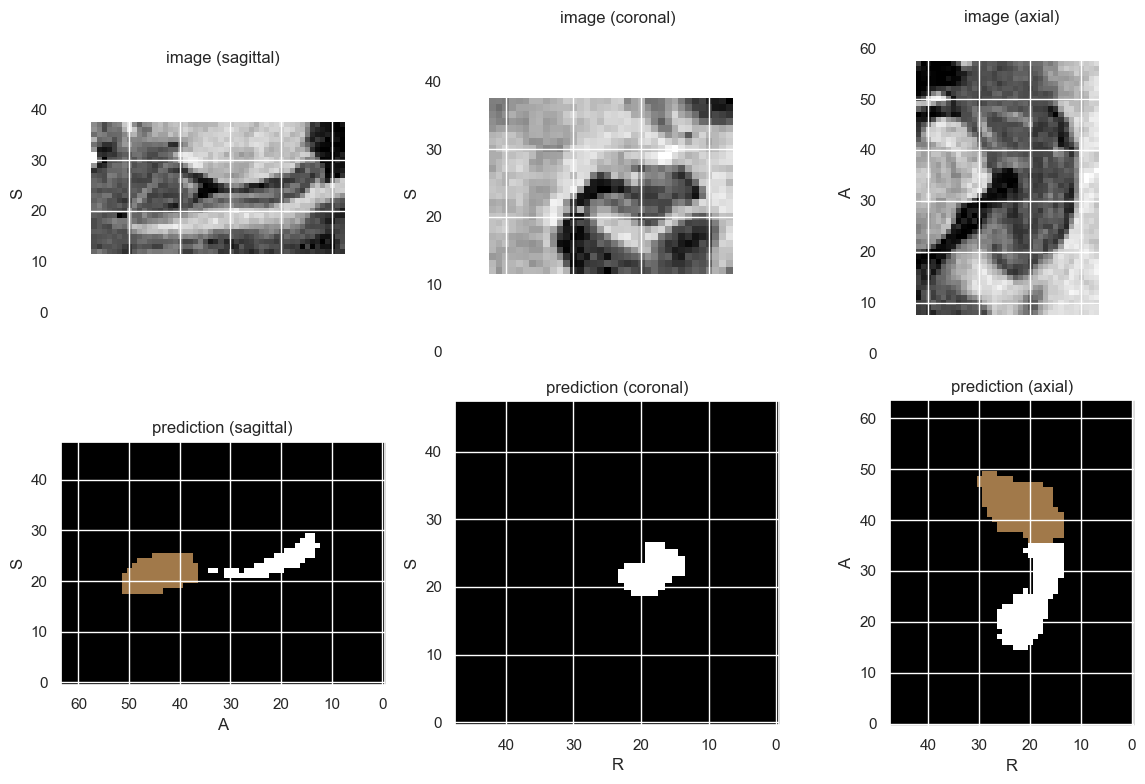

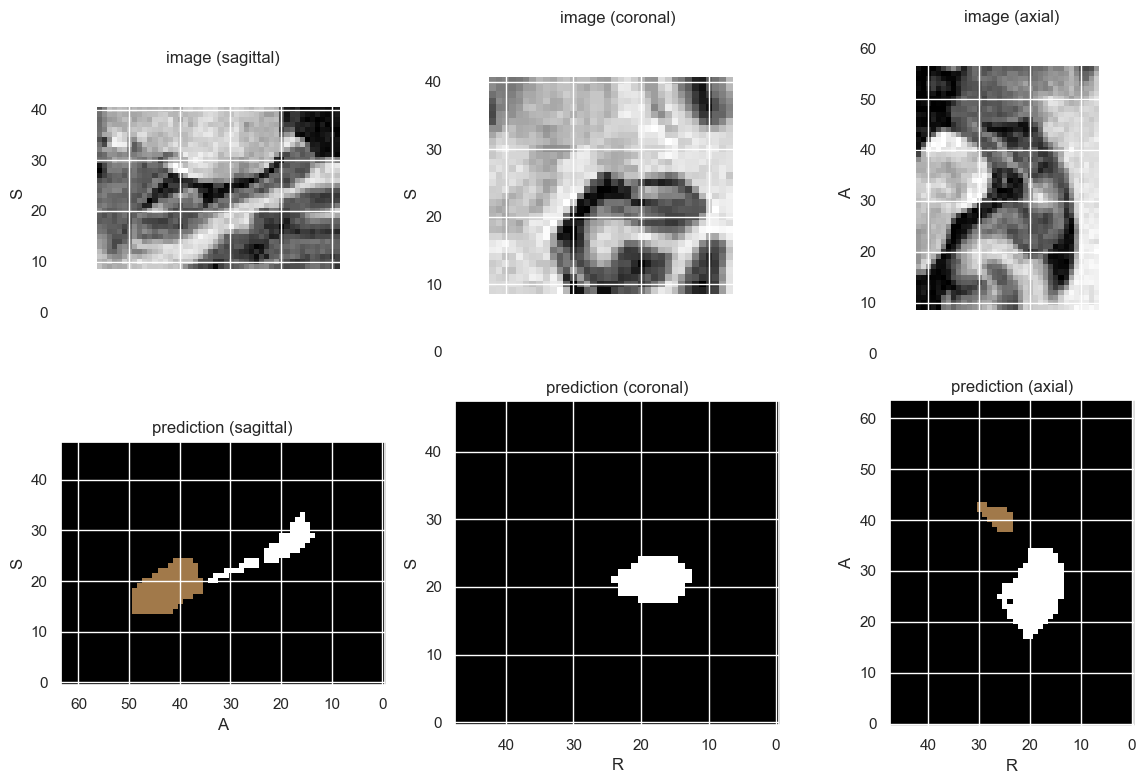

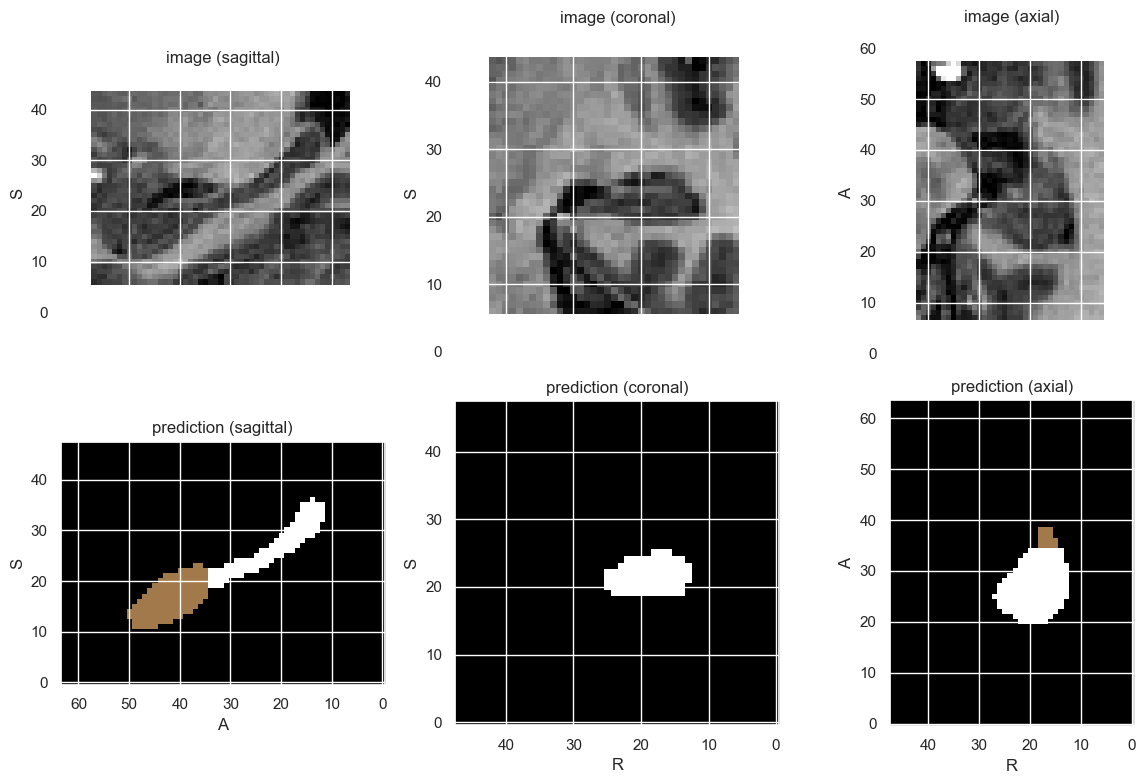

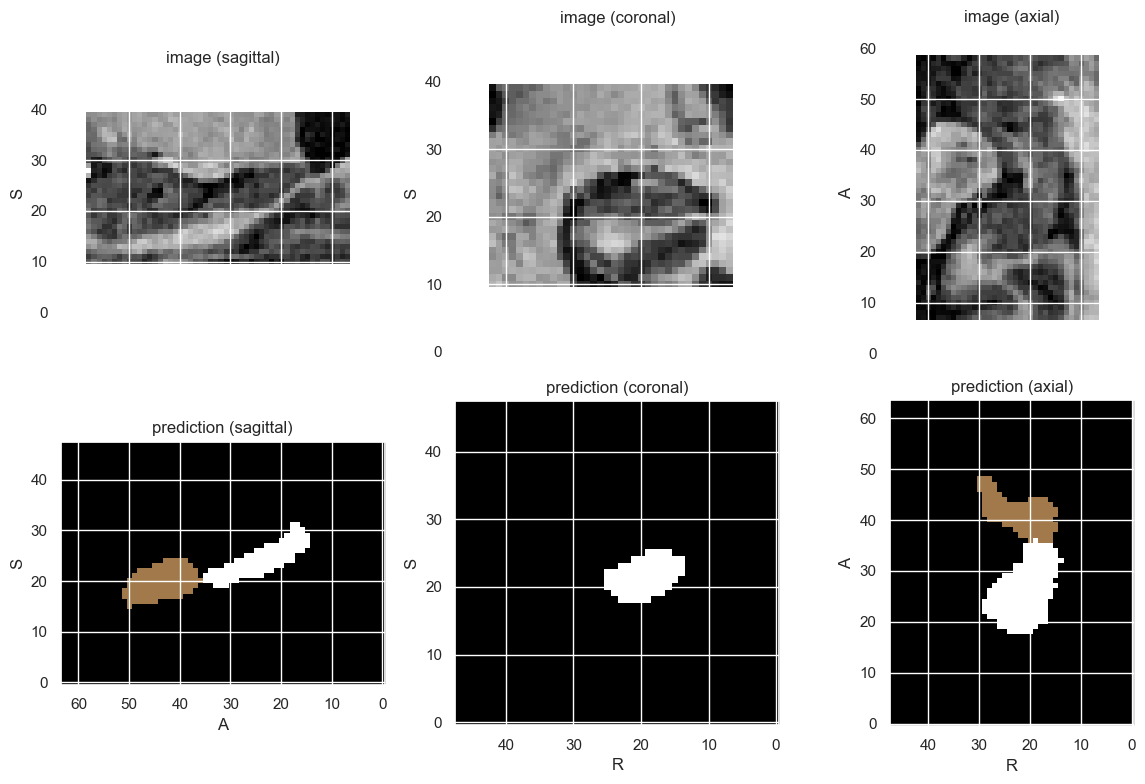

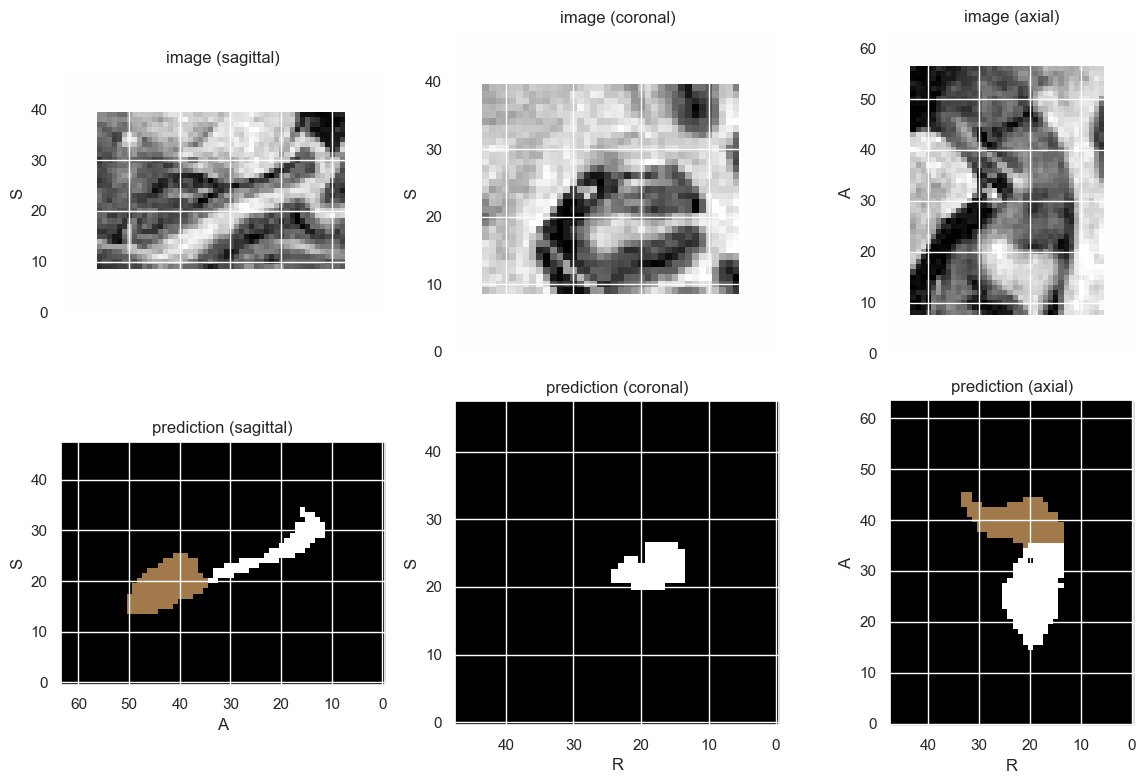

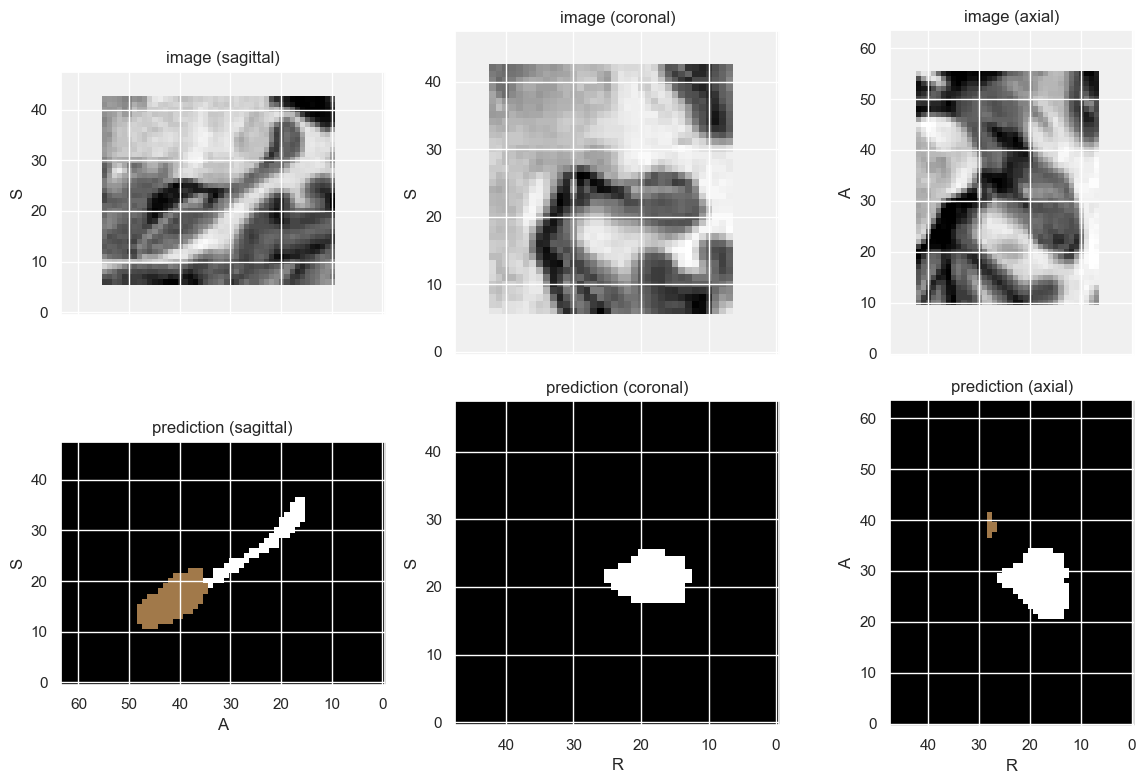

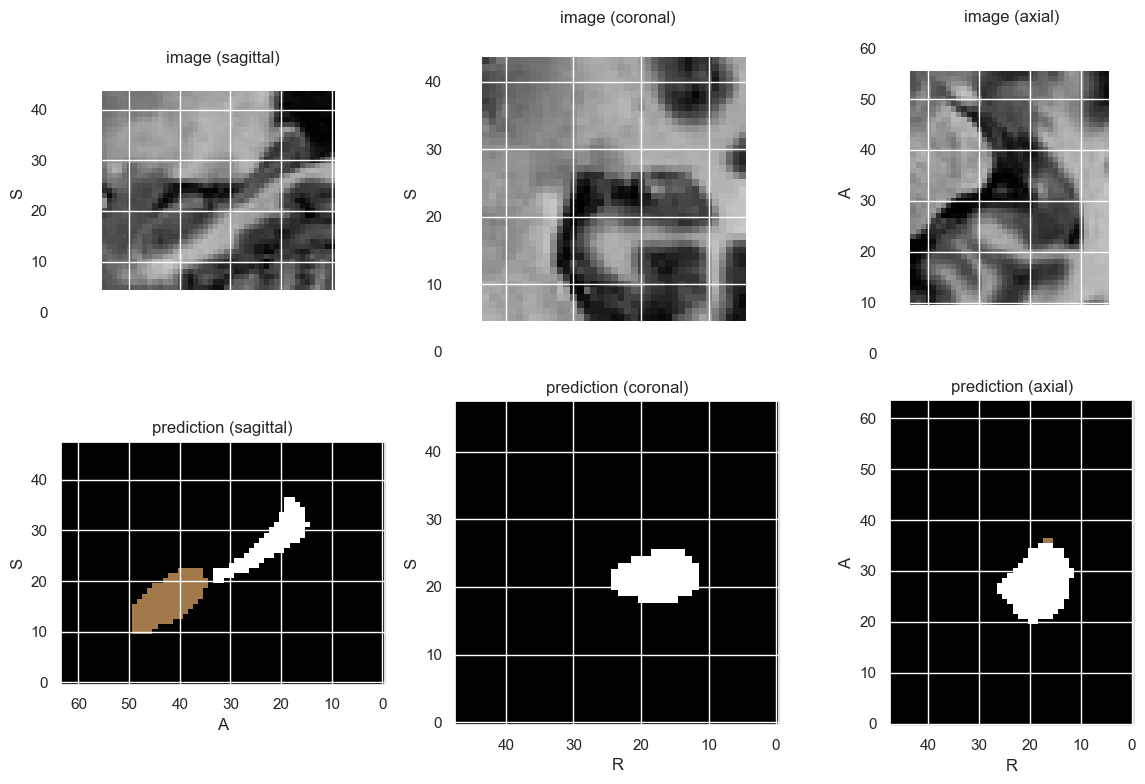

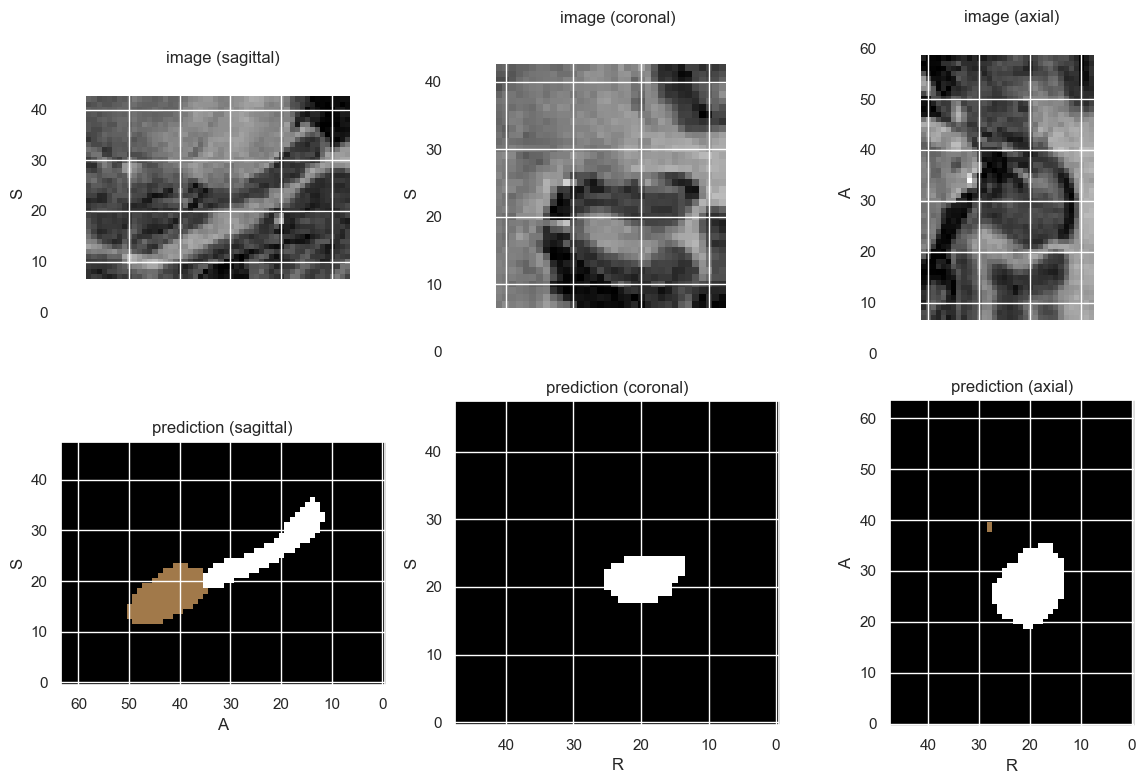

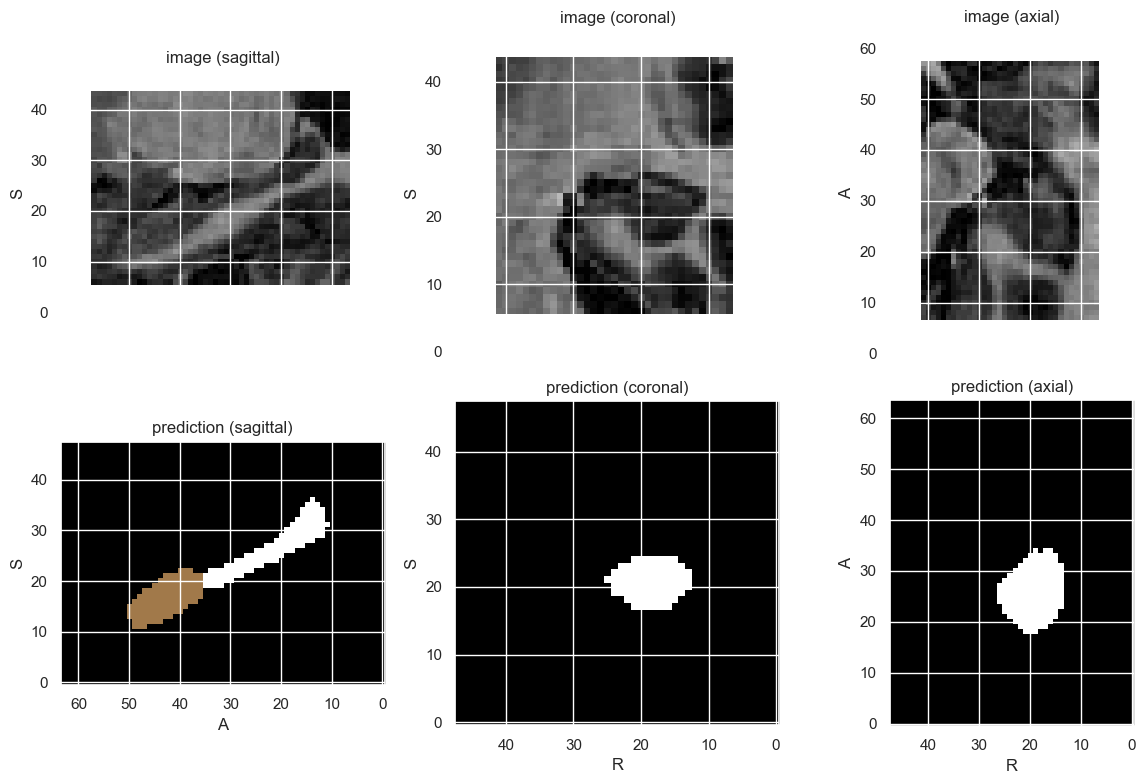

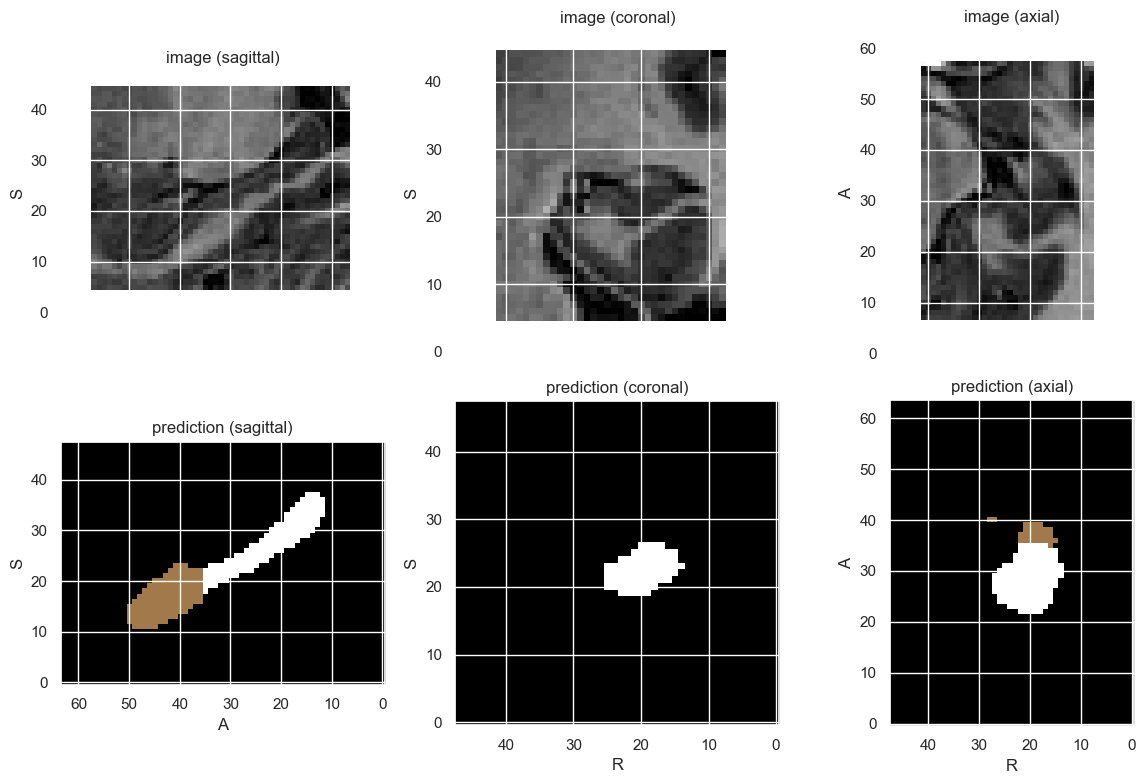

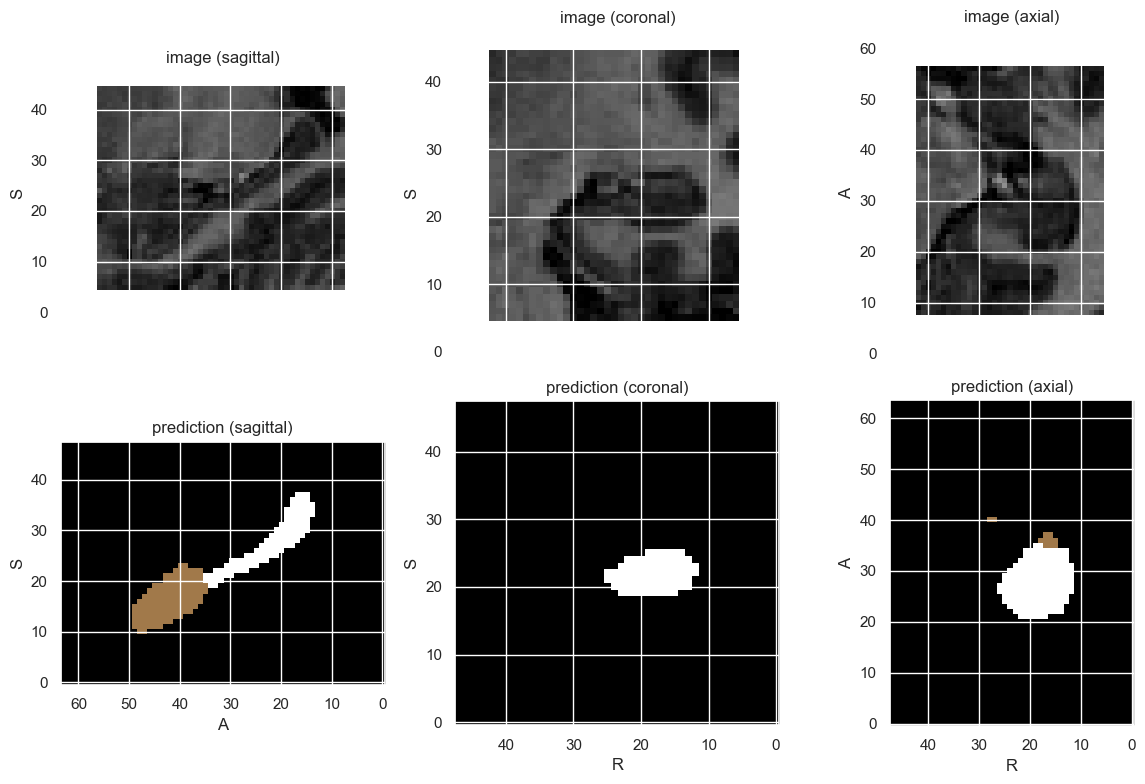

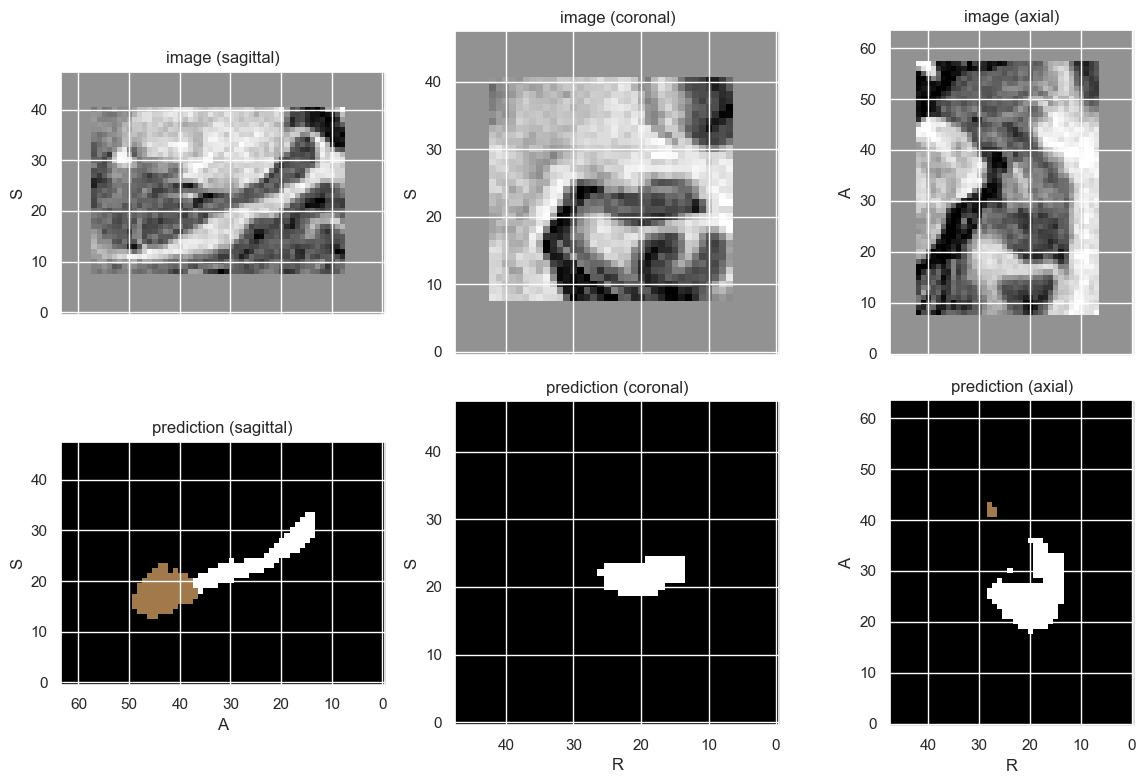

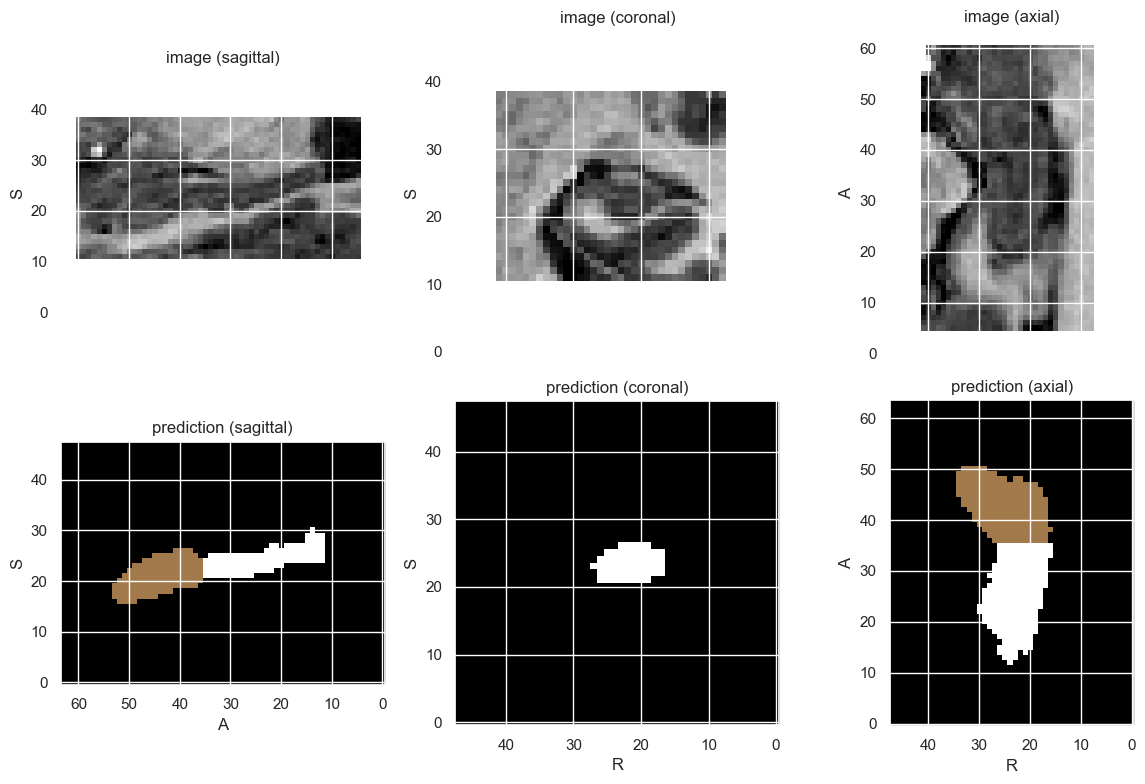

In [18]:
for subject in batch_subjects:
    subject.plot()